## Cluster analysis of TCGA breast cancer sets

Here we are perfoming a k-means analysis of two different datasets within the TCGA. 

First we retrieve the breast cancer RNAseq data as well as the clinical classification of the sets from cbioportal.org. The code for the retrieval of this set is not important for the understanding of the analysis. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import urllib.request
import tarfile
import gzip
import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

def get_tar(url,path):
    try:
        tf = tarfile.open(path)
    except:
        track_dl(url, path)
        tf = tarfile.open(path)
    return tf

def get_expression_data(path,url,file):
    df = get_data(path,url,file)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
#    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    df.drop(columns=['Entrez_Gene_Id'], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_clinical_data(path,url,file):
    df = get_data(path,url,file).T
    df.columns = df.iloc[2]
#    df.drop(columns=["A unique sample identifier.","STRING","1","SAMPLE_ID"], inplace=True)
    df.drop(columns=["STRING","1"], inplace=True)
    df.drop(index=["Unnamed: 0","#Patient Identifier","Sample Identifier","Other Sample ID"], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_data(path,url,file):
    try:
        df = pd.read_csv(gzip.open(path,'rb'), sep="\t")
    except:
#        urllib.request.urlretrieve(url, "my.tar.gz")
        tf = get_tar(url,"my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(gzip.open(path,'wb'), sep="\t")
    return df

brca = get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")


We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0.

In [2]:
#combined = pd.concat([lusc, luad], axis=1, sort=False)
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)

Make a k-means clustering with k=2.

In [3]:
from sklearn.cluster import KMeans
import numpy as np

X = brca.values.T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
#brca_clin_T.loc["2N"] = [list(kmeans.labels_)]
#brca_clin_T.loc["Cluster_2"] = kmeans.labels_
label_df = pd.DataFrame(columns=brca.columns,index=["Cluster_2"],data=[list(kmeans.labels_)])
brca_clin=brca_clin.append(label_df,sort=True)



Compare the clusters to wich patients that have been marked as [Progesterone receptor](https://en.wikipedia.org/wiki/Progesterone_receptor) Negative and [Estrogen receptor](https://en.wikipedia.org/wiki/Estrogen_receptor) Negative. Such cancers are known to behave different than other cancers, and are less amendable to [hormonal theraphy](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)).

In [4]:
brca_clin.loc["2N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative")
confusion_matrix = pd.crosstab(brca_clin.loc['2N'], brca_clin.loc['Cluster_2'], rownames=['PR-&ER-'], colnames=['Cluster'])
confusion_matrix

Cluster,0,1
PR-&ER-,,
False,615,41
True,23,139


For n_clusters = 2 The average silhouette_score is : 0.1485129743411804
For n_clusters = 3 The average silhouette_score is : 0.07081665699878875
For n_clusters = 4 The average silhouette_score is : 0.059878965965213186
For n_clusters = 5 The average silhouette_score is : 0.05573739138512621
For n_clusters = 6 The average silhouette_score is : 0.05563580275570598


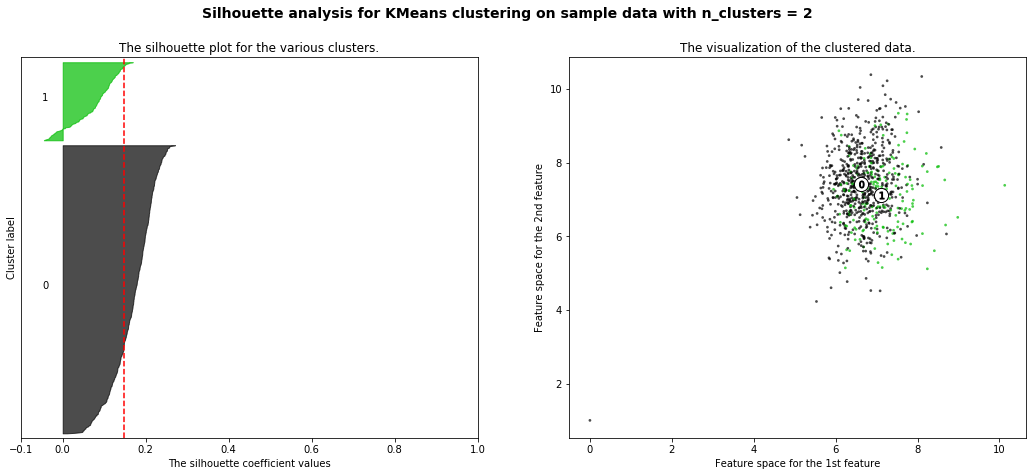

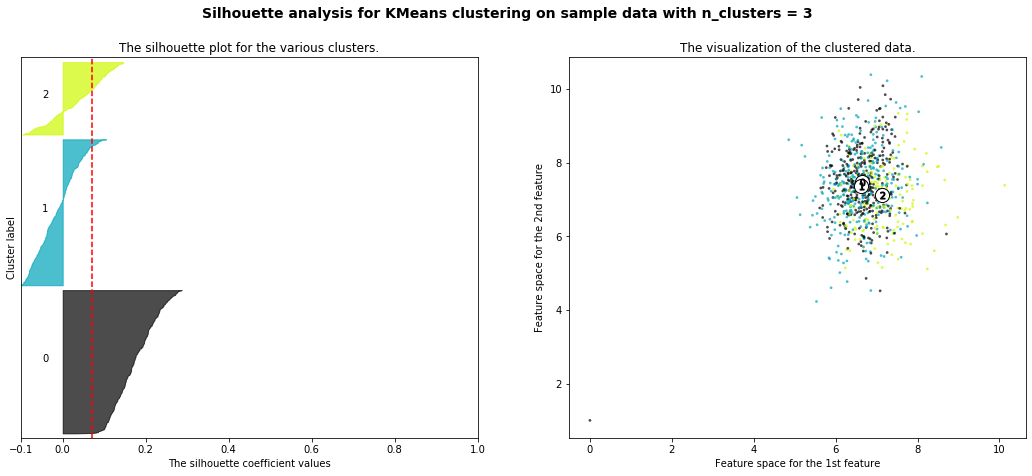

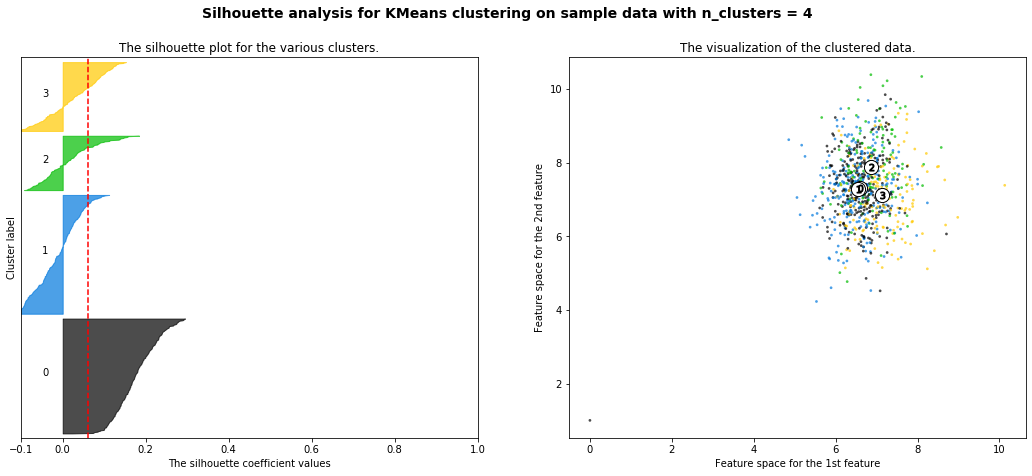

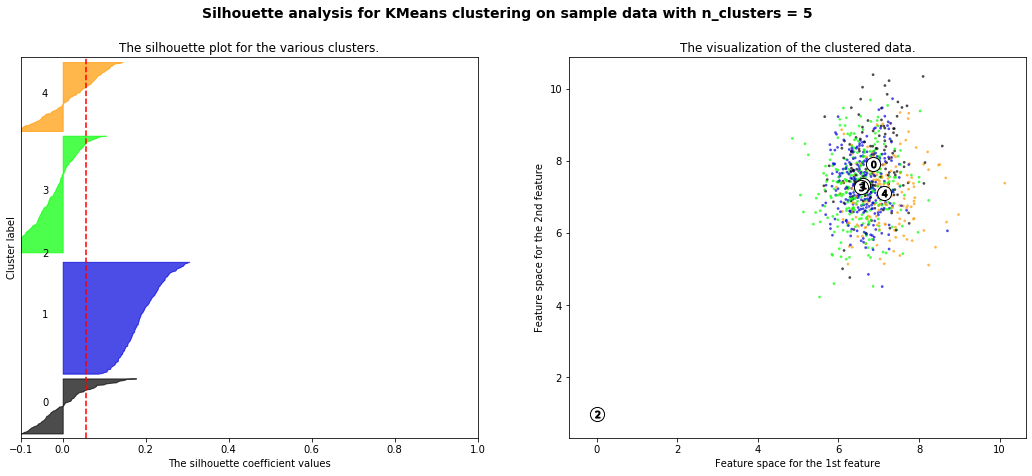

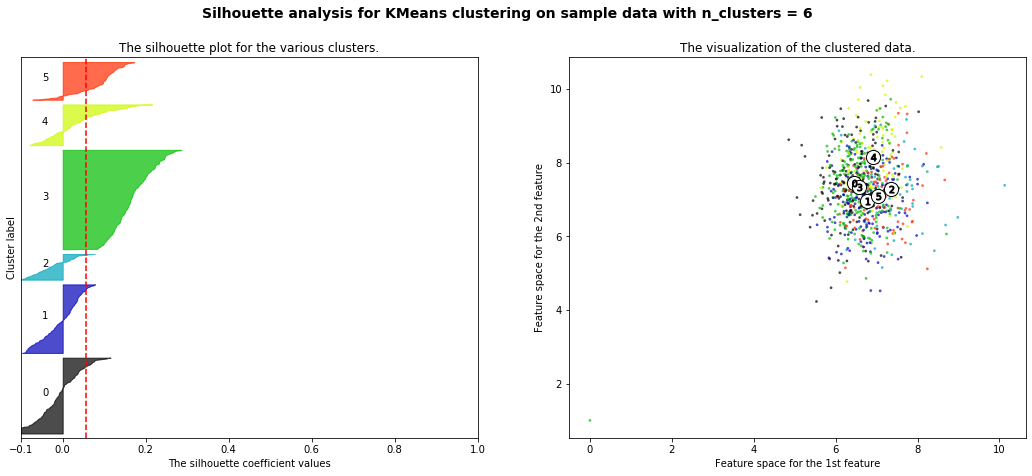

In [5]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [6]:
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='diag', random_state=0).fit(X)
label_df = pd.DataFrame(columns=brca.columns,index=["GMM_2"],data=[list(gmm.predict(X))])
brca_clin=brca_clin.append(label_df,sort=True)


In [7]:
confusion_matrix = pd.crosstab(brca_clin.loc['2N'], brca_clin.loc['GMM_2'], rownames=['PR-&ER-'], colnames=['Component'])
confusion_matrix

Component,0,1
PR-&ER-,,
False,196,460
True,149,13


In [8]:
brca_clin.loc["3N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative") & (brca_clin.loc["IHC-HER2"]=="Negative")
confusion_matrix = pd.crosstab(brca_clin.loc['3N'], brca_clin.loc['GMM_2'], rownames=['PR-&ER-'], colnames=['Component'])
confusion_matrix

Component,0,1
PR-&ER-,,
False,265,470
True,80,3
